In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from PIL import Image
from collections import OrderedDict
from torchvision.models.detection.image_list import ImageList
from torchvision.ops import nms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 데이터셋 다운로드

import os
import urllib.request
import tarfile

# 데이터셋 다운로드 경로
dataset_url = 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'
dataset_dir = 'PennFudanPed'

# 데이터셋이 없을 경우 다운로드 및 압축 해제
if not os.path.exists(dataset_dir):
    print("데이터셋을 다운로드 중입니다...")
    urllib.request.urlretrieve(dataset_url, 'PennFudanPed.zip')
    print("압축 해제 중입니다...")
    import zipfile
    with zipfile.ZipFile('PennFudanPed.zip', 'r') as zip_ref:
        zip_ref.extractall()
    print("데이터셋 준비가 완료되었습니다.")
else:
    print("데이터셋이 이미 존재합니다.")

데이터셋을 다운로드 중입니다...
압축 해제 중입니다...
데이터셋 준비가 완료되었습니다.


In [3]:
# 데이터 resize 및 tensor로 변환

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class Resize(object):
    def __init__(self, size):
        self.size = size  # (width, height)

    def __call__(self, image, target):
        # 원본 이미지 크기
        w, h = image.size

        # 새로운 이미지 크기
        new_w, new_h = self.size

        # 이미지 리사이즈
        image = image.resize((new_w, new_h), Image.BILINEAR)

        # 바운딩 박스 좌표 조정
        if "boxes" in target:
            boxes = target["boxes"]
            boxes = boxes * torch.tensor([new_w / w, new_h / h, new_w / w, new_h / h])
            target["boxes"] = boxes

        # 마스크 리사이즈
        if "masks" in target:
            masks = target["masks"]
            masks = masks.unsqueeze(0)  # (N, H, W) -> (1, N, H, W)
            masks = nn.functional.interpolate(masks, size=(new_h, new_w), mode='nearest')
            masks = masks.squeeze(0)
            target["masks"] = masks

        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = transforms.functional.to_tensor(image)
        return image, target

transform = Compose([
    Resize((800, 800)),
    ToTensor()
])

In [4]:
# 데이터셋 준비

class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

# 데이터셋 로드
dataset = PennFudanDataset('PennFudanPed', transforms=transform)
dataset_test = PennFudanDataset('PennFudanPed', transforms=transform)

# 데이터셋 분할
indices = torch.randperm(len(dataset)).tolist()
split_index = int(len(indices) * 0.8)
dataset = torch.utils.data.Subset(dataset, indices[:split_index])
dataset_test = torch.utils.data.Subset(dataset_test, indices[split_index:])

# 데이터 로더 생성
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)


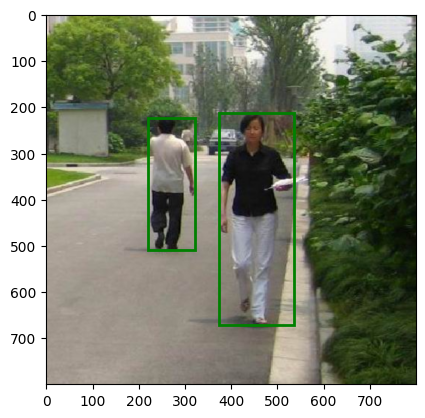

In [5]:
# 이미지 및 바운딩 박스 샘플 확인

sample_img, sample_target = data_loader_test.dataset[0]
sample_img = sample_img.permute(1, 2, 0).numpy()
sample_boxes = sample_target['boxes'].numpy()
plt.imshow(sample_img)
for box in sample_boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='g', linewidth=2))

In [6]:
# RPN 앵커 및 백본(ResNet50) 설정

from torchvision.models.detection.rpn import AnchorGenerator

##############################
# 1. RPN 앵커의 크기 및 종횡비를 설정하세요
##############################
anchor_generator = AnchorGenerator(
    sizes=((128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
###############################

# ResNet50 백본 사용
backbone = models.resnet50(pretrained=True).to(device)

# 마지막 분류 계층 제거
modules = list(backbone.children())[:-2]
backbone = nn.Sequential(*modules)

backbone.out_channels = 2048  # ResNet50의 마지막 특징 맵 채널 수


c:\Users\skepc\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\skepc\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\skepc/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
# RPN, RoI Pooler 생성

from torchvision.models.detection.rpn import RegionProposalNetwork, RPNHead

rpn_head = RPNHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0])

rpn = RegionProposalNetwork(
    anchor_generator,
    rpn_head,
    fg_iou_thresh=0.7,
    bg_iou_thresh=0.3,
    batch_size_per_image=256,
    positive_fraction=0.5,
    pre_nms_top_n=dict(training=2000, testing=1000),
    post_nms_top_n=dict(training=2000, testing=1000),
    nms_thresh=0.7
)

from torchvision.ops import RoIAlign

roi_pooler = RoIAlign(
    output_size=(7, 7),
    ###################
    # 2. spatial_scale을 설정하세요.
    # 백본의 feature map 크기와 output_size를 고려하여 설정하세요.
    ###################
    spatial_scale=1/32,
    ###################
    sampling_ratio=2
)


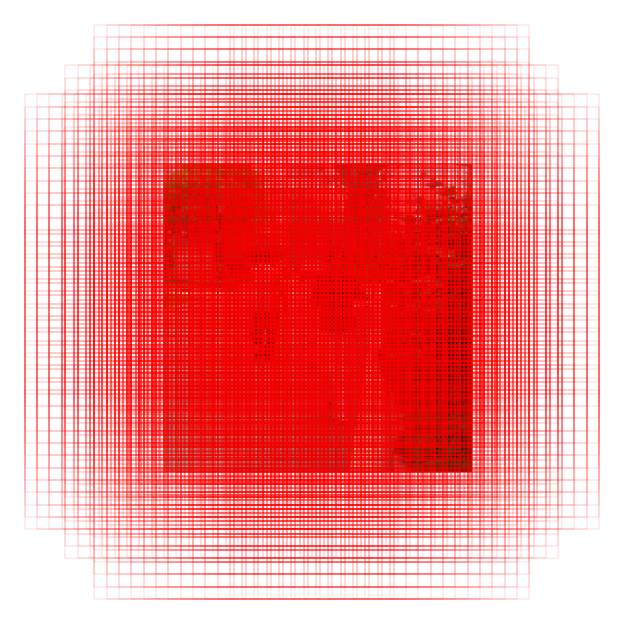

In [8]:
# 앵커 박스 확인

# 샘플 이미지 가져오기
sample_img, _ = data_loader_test.dataset[0]
sample_img_np = sample_img.permute(1, 2, 0).numpy()
sample_img = sample_img.to(device)

# 앵커 박스 생성
imglist = ImageList(sample_img.unsqueeze(0), [(800, 800)])
feature_map = backbone(sample_img.unsqueeze(0)).to(device)
anchors = anchor_generator(imglist, [feature_map])

# 샘플 이미지 출력
fig, ax = plt.subplots(1, figsize=(12, 8))

# 넓게 보기 위해 xlim과 ylim 설정
margin = 400
ax.set_xlim(-margin, 800 + margin)
ax.set_ylim(800 + margin, -margin)
ax.imshow(sample_img_np)

# 앵커 박스 시각화
for anchor in anchors:
    for box in anchor:
        box = box.cpu().numpy()
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=0.1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
plt.show()

In [9]:
# FasterRCNNHead 생성

################ 성능 향상을 위해 조절하기 과제가 가능할 것 같습니다. ################
class FasterRCNNHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FasterRCNNHead, self).__init__()
        #############################################
        # 3. fc1, fc2, classifier, box_regressor를 forward를 참고해 구현하세요.
        # classifier는 num_classes만큼의 클래스를 출력해야 합니다.
        # box_regressor는 (num_classes-1) * 4만큼의 값을 출력해야 합니다.
        #############################################
        self.fc1 = nn.Linear(in_channels * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.classifier = nn.Linear(1024, num_classes)
        self.box_regressor = nn.Linear(1024, (num_classes-1) * 4)
        #############################################

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        scores = self.classifier(x)
        bbox_deltas = self.box_regressor(x)
        return scores, bbox_deltas


In [10]:
# FasterRCNN 모델 생성

from torchvision.ops.boxes import box_iou

class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn, roi_pooler, head, num_classes,
                 min_size=800, max_size=1333,
                 score_thresh=0.05, nms_thresh=0.5, detections_per_img=100):
        super(FasterRCNN, self).__init__()
        self.backbone = backbone

        # backbone train 여부 조절
        # for param in self.backbone.parameters():
        #     param.requires_grad = False

        self.rpn = rpn
        self.roi_pooler = roi_pooler
        self.head = head
        self.num_classes = num_classes

        # 후처리에 필요한 설정값들
        self.score_thresh = score_thresh  # 점수 임계값
        self.nms_thresh = nms_thresh      # NMS 임계값
        self.detections_per_img = detections_per_img  # 이미지당 최대 검출 수

        self.min_size = min_size
        self.max_size = max_size

    def transform(self, images):
        # 이미지 크기 조정 및 정규화 (필요한 경우)
        image_sizes = [img.shape[-2:] for img in images]
        images = [img for img in images]
        images = torch.stack(images)
        return ImageList(images, image_sizes)

    def forward(self, images, targets=None):
        # 이미지 전처리
        if self.training:
            assert targets is not None
        images = self.transform(images)

        # 특징 추출
        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([('0', features)])

        # RPN 단계
        proposals, rpn_losses = self.rpn(images, features, targets)

        # RoI 풀링
        box_features = self.roi_pooler(features['0'], proposals)

        # 분류 및 회귀 헤드
        class_logits, box_regression = self.head(box_features)
        box_regression = box_regression.view(-1, self.num_classes-1, 4)

        result = []
        losses = {}

        if self.training:
            # 학습 시 손실 계산
            detector_losses = self.compute_loss(class_logits, box_regression, targets, proposals)
            losses.update(rpn_losses)
            losses.update(detector_losses)
            return losses
        else:
            # 추론 시 결과 반환
            detections = self.postprocess_detections(class_logits, box_regression, proposals, images.image_sizes)
            return detections

    def compute_loss(self, class_logits, box_regression, targets, proposals):
        # 각 이미지에 대해 타겟 할당 및 손실 계산
        labels, regression_targets = self.assign_targets_to_proposals(proposals, targets)

        # 분류 손실 계산
        loss_classifier = F.cross_entropy(class_logits, labels)

        # 박스 회귀 손실 계산
        box_regression = box_regression.view(-1, self.num_classes-1, 4)

        # 배경이 아닌 인덱스 선택
        foreground_indices = labels > 0
        labels_pos = labels[foreground_indices] - 1  # 클래스 인덱스 조정 (1부터 시작하므로 1 빼기)

        # 유효한 예측과 타겟 추출
        box_regression = box_regression[foreground_indices, labels_pos]
        regression_targets = regression_targets[foreground_indices]

        # Smooth L1 손실 계산
        loss_box_reg = F.smooth_l1_loss(
            box_regression, regression_targets, beta=1/9, reduction='sum') / labels.numel()

        return {'loss_classifier': loss_classifier, 'loss_box_reg': loss_box_reg}

    def assign_targets_to_proposals(self, proposals, targets):
        labels = []
        matched_gt_boxes = []
        for proposals_per_image, targets_per_image in zip(proposals, targets):
            device = proposals_per_image.device
            gt_boxes = targets_per_image["boxes"].to(device)
            gt_labels = targets_per_image["labels"].to(device)

            if gt_boxes.numel() == 0:
                # 타겟이 없는 경우 모든 proposals를 배경으로 처리
                labels_per_image = torch.zeros((proposals_per_image.shape[0],), dtype=torch.int64, device=device)
                matched_gt_boxes_per_image = torch.zeros_like(proposals_per_image)
            else:
                # IoU 계산
                ious = box_iou(proposals_per_image, gt_boxes)

                # 각 proposal에 대해 최대 IoU를 가지는 gt 박스의 인덱스와 IoU 값 얻기
                max_iou_values, gt_assignment = ious.max(dim=1)

                # 라벨 초기화 (배경은 0)
                labels_per_image = torch.zeros((proposals_per_image.shape[0],), dtype=torch.int64, device=device)

                # 포그라운드와 배경 구분을 위한 임계값 설정
                foreground_idxs = max_iou_values >= 0.5
                background_idxs = max_iou_values < 0.5

                # 포그라운드인 proposals에 gt 라벨 할당
                labels_per_image[foreground_idxs] = gt_labels[gt_assignment[foreground_idxs]]

                # 매칭된 gt 박스 저장
                matched_gt_boxes_per_image = gt_boxes[gt_assignment]

            labels.append(labels_per_image)
            matched_gt_boxes.append(matched_gt_boxes_per_image)

        labels = torch.cat(labels, dim=0)
        regression_targets = self.box_coder_encode(torch.cat(proposals, dim=0), torch.cat(matched_gt_boxes, dim=0))

        return labels, regression_targets


    def get_regression_targets(self, proposals, targets):
        regression_targets = []
        for proposals_per_image, targets_per_image in zip(proposals, targets):
            if targets_per_image["boxes"].numel() == 0:
                # 타겟이 없는 경우 회귀 타겟은 0으로 설정
                regression_targets_per_image = torch.zeros_like(proposals_per_image)
            else:
                # 각 proposal에 해당하는 타겟 박스를 가져옴
                target_boxes = targets_per_image["boxes"][0].expand(proposals_per_image.shape[0], 4)
                regression_targets_per_image = self.box_coder_encode(proposals_per_image, target_boxes)

            regression_targets.append(regression_targets_per_image)

        regression_targets = torch.cat(regression_targets, dim=0)
        return regression_targets
    def box_coder_encode(self, proposals, targets):
        # 박스 코딩 (targets - proposals)
        wx, wy, ww, wh = (1.0, 1.0, 1.0, 1.0)
        proposals = proposals.float()
        targets = targets.float()

        px = (proposals[:, 0] + proposals[:, 2]) / 2
        py = (proposals[:, 1] + proposals[:, 3]) / 2
        pw = proposals[:, 2] - proposals[:, 0]
        ph = proposals[:, 3] - proposals[:, 1]

        gx = (targets[:, 0] + targets[:, 2]) / 2
        gy = (targets[:, 1] + targets[:, 3]) / 2
        gw = targets[:, 2] - targets[:, 0]
        gh = targets[:, 3] - targets[:, 1]

        dx = wx * (gx - px) / pw
        dy = wy * (gy - py) / ph
        dw = ww * torch.log(gw / pw)
        dh = wh * torch.log(gh / ph)

        return torch.stack((dx, dy, dw, dh), dim=1)

    def postprocess_detections(self, class_logits, box_regression, proposals, image_sizes):
        device = class_logits.device
        num_classes = self.num_classes

        # 분류 점수 계산
        pred_scores = F.softmax(class_logits, -1)

        # 이미지별로 결과 분리
        boxes_per_image = [len(p) for p in proposals]
        pred_scores_list = pred_scores.split(boxes_per_image, dim=0)
        box_regression_list = box_regression.split(boxes_per_image, dim=0)
        results = []

        for scores, box_regression_per_image, proposals_per_image, image_size in zip(pred_scores_list, box_regression_list, proposals, image_sizes):
            if isinstance(proposals_per_image, list):
                # 리스트를 텐서로 변환
                if len(proposals_per_image) == 0:
                    # proposals_per_image가 비어있는 경우 빈 텐서를 생성
                    proposals_per_image = torch.empty((0, 4), device=device)
                else:
                    proposals_per_image = torch.stack(proposals_per_image)
            else:
                proposals_per_image = proposals_per_image.to(device)

            # 박스 디코딩
            pred_boxes = self.box_coder_decode(box_regression_per_image, proposals_per_image)
            # 결과 필터링
            boxes, labels, scores = self.filter_results(pred_boxes, scores, image_size)
            results.append({'boxes': boxes, 'labels': labels, 'scores': scores})
        return results


    def box_coder_decode(self, rel_codes, boxes):
        # boxes가 텐서인지 확인하고, 아니면 텐서로 변환
        if isinstance(boxes, list):
            boxes = torch.stack(boxes)
        boxes = boxes.to(rel_codes.dtype)
        total_boxes = boxes.size(0)
        num_classes = self.num_classes-1

        rel_codes = rel_codes.view(total_boxes, num_classes, 4)
        boxes = boxes[:, None, :].expand(total_boxes, num_classes, 4)

        # 이후 코드 동일
        px = (boxes[..., 0] + boxes[..., 2]) * 0.5
        py = (boxes[..., 1] + boxes[..., 3]) * 0.5
        pw = boxes[..., 2] - boxes[..., 0]
        ph = boxes[..., 3] - boxes[..., 1]

        dx = rel_codes[..., 0]
        dy = rel_codes[..., 1]
        dw = rel_codes[..., 2]
        dh = rel_codes[..., 3]

        gx = dx * pw + px
        gy = dy * ph + py
        gw = pw * torch.exp(dw)
        gh = ph * torch.exp(dh)

        x1 = gx - gw * 0.5
        y1 = gy - gh * 0.5
        x2 = gx + gw * 0.5
        y2 = gy + gh * 0.5

        decoded_boxes = torch.stack([x1, y1, x2, y2], dim=-1)
        return decoded_boxes


    def filter_results(self, boxes, scores, image_shape):
        num_classes = scores.shape[1]  # 배경 클래스를 포함한 클래스 수
        device = scores.device

        # 결과를 저장할 리스트 초기화
        final_boxes = []
        final_scores = []
        final_labels = []

        # 각 클래스에 대해 반복 (배경 클래스는 인덱스 0이므로 건너뜀)
        for cls_ind in range(1, num_classes):
            cls_scores = scores[:, cls_ind]
            cls_boxes = boxes  # 박스는 모든 클래스에서 공유
            cls_boxes = cls_boxes.view(-1, 4)
            # 점수 임계값 적용
            score_keep = cls_scores > self.score_thresh
            cls_scores = cls_scores[score_keep]
            cls_boxes = cls_boxes[score_keep]


            if cls_boxes.numel() == 0:
                continue  # 남은 박스가 없으면 다음 클래스로

            # NMS 적용
            nms_indices = nms(cls_boxes, cls_scores, self.nms_thresh)
            nms_indices = nms_indices[:self.detections_per_img]

            cls_scores = cls_scores[nms_indices]
            cls_boxes = cls_boxes[nms_indices]

            # 레이블 할당 (현재 클래스)
            cls_labels = torch.full((len(nms_indices),), cls_ind, dtype=torch.int64, device=device)

            final_boxes.append(cls_boxes)
            final_scores.append(cls_scores)
            final_labels.append(cls_labels)

        if len(final_boxes) == 0:
            # 검출된 결과가 없으면 빈 텐서 반환
            return torch.empty((0, 4), device=device), torch.empty((0,), device=device), torch.empty((0,), dtype=torch.int64, device=device)

        # 모든 클래스의 결과를 연결
        boxes = torch.cat(final_boxes, dim=0)
        scores = torch.cat(final_scores, dim=0)
        labels = torch.cat(final_labels, dim=0)

        # 검출 수 제한
        if boxes.numel() > 0:
            scores, order = scores.sort(descending=True)
            order = order[:self.detections_per_img]
            boxes = boxes[order]
            labels = labels[order]
            scores = scores[:self.detections_per_img]

        # 박스 좌표를 이미지 크기에 맞게 조정
        boxes[:, 0].clamp_(min=0, max=image_shape[1])  # x1
        boxes[:, 1].clamp_(min=0, max=image_shape[0])  # y1
        boxes[:, 2].clamp_(min=0, max=image_shape[1])  # x2
        boxes[:, 3].clamp_(min=0, max=image_shape[0])  # y2

        return boxes, labels, scores

In [ ]:
############# 학습 시 사용되는 파라미터들 및 옵티마이저를 조절하는 과제가 가능할 것 같습니다. ####################
import os
num_classes = 2  # 배경 0 사람 1
model = FasterRCNN(backbone, rpn, roi_pooler, FasterRCNNHead(backbone.out_channels, num_classes), num_classes)
model.to(device)
model_save_path = 'fasterrcnn_model.pth'

# 랜덤 시드 고정
torch.manual_seed(0)
np.random.seed(0)

alpha = 0.5

FORCED_TRAIN = False# True #False
if not FORCED_TRAIN and os.path.exists(model_save_path):
    checkpoint = torch.load(model_save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    print("저장된 모델을 불러왔습니다.")
else:
    print("저장된 모델이 없습니다. 학습을 시작합니다.")

    best_test_loss = float('inf')
    best_params = None

    params = [p for p in model.parameters() if p.requires_grad]
    ##################################
    # 4. optimizer와 scheduler를 설정하세요.
    # 적절한 optimizer를 선택하고, lr과 weight_decay를 조절하세요.
    ##################################
    optimizer = torch.optim.Adam(params, lr=0.6, weight_decay=0.005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)
    ##################################
    num_epochs = 20

    for epoch in range(num_epochs):
        model.train()
        i = 0
        total_loss = 0
        for images, targets in data_loader:

            images = [image.to(device) for image in images]
            images = torch.stack(images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            total_loss += losses.item()

            # if i % 10 == 0:
            #     print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(data_loader)}], Loss: {losses.item():.4f}")
            i += 1

        scheduler.step()
        print('======================================')
        print(f"Epoch [{epoch+1}] completed.")
        # 한 에폭마다 train loss, test loss 계산
        with torch.no_grad():

            test_loss = 0
            for images, targets in data_loader_test:
                images = [image.to(device) for image in images]
                images = torch.stack(images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                test_loss += losses.item()
            print(f"Train Loss: {total_loss / len(data_loader):.4f}")
            print(f"Test Loss: {test_loss / len(data_loader_test):.4f}")
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_params = copy.deepcopy(model.state_dict())
                print("Best model updated.")
        print('======================================')


    # 모델 저장
    model.load_state_dict(best_params)
    checkpoint = {
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, model_save_path)
    print("모델을 저장하였습니다.")

저장된 모델이 없습니다. 학습을 시작합니다.
Epoch [1] completed.
Train Loss: nan
Test Loss: nan
Epoch [2] completed.
Train Loss: nan
Test Loss: 25625995.2997
Best model updated.
Epoch [3] completed.
Train Loss: 6269552.6741
Test Loss: 290567.4496
Best model updated.
Epoch [4] completed.
Train Loss: 65802.2701
Test Loss: 3717.6262
Best model updated.
Epoch [5] completed.
Train Loss: 2372.2606
Test Loss: 1173.4275
Best model updated.
Epoch [6] completed.
Train Loss: 855.2249
Test Loss: 382.5451
Best model updated.
Epoch [7] completed.
Train Loss: 312.5030
Test Loss: 257.0103
Best model updated.


In [ ]:
# test 데이터 추론 결과 시각화

try:
    print(f'Best_test_loss: {best_test_loss / len(data_loader_test):.4f}')
except:
    pass

model.eval()
i = 0
for images, targets in data_loader_test:
    images = [image.to(device) for image in images]
    images = torch.stack(images)
    # print(images)
    with torch.no_grad():
        predictions = model(images)
        # print(predictions)

    # 첫 번째 이미지와 예측 결과 가져오기
    img = images[0].permute(1, 2, 0).cpu().numpy()
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_labels = predictions[0]['labels'].cpu().numpy()

    # 예측된 바운딩 박스 그리기
    top_predictions = 3
    top_scores = sorted(pred_scores, reverse=True)[:top_predictions]

    if len(top_scores) == 0 or top_scores[0] < 0.000:
        continue

    # 원본 이미지 시각화
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        if score < top_scores[-1]:
            continue
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, f'{score:.2f}', color='red', fontsize=12, weight='bold')

    # # 타겟 바운딩 박스 그리기 (옵션)
    # target_boxes = targets[0]['boxes'].cpu().numpy()
    # for box in target_boxes:
    #     xmin, ymin, xmax, ymax = box
    #     width, height = xmax - xmin, ymax - ymin
    #     rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='g', facecolor='none')
    #     ax.add_patch(rect)

    plt.axis('off')
    plt.show()

    i += 1
    if i == 5:
        break


Best_test_loss: 1.4418
